# Effects of Flight Characteristics on Delay Frequencies and Duration

### Investigation and Dataset Overview 

The goal of this analysis was to identify factors contributing to flight delays. The dataset used was flight data for American-based airlines and flights for 2008. The dataset contained both delayed and on-time flights, but different sub-sects of the dataset were used for the analysis when specified below. 

***All delays shown are in minutes***


### Import & Clean Data

In [4]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sb
%matplotlib inline

In [5]:
df = pd.read_csv('data/flight_data.csv')

In [6]:
#rename columns so they are easier to interpret 

df = df.rename(columns = {'CRSDepTime':'sched_depart',
                    'DepTime':'actual_depart',
                    'ArrTime':'actual_arrival',
                    'CRSArrTime':'sched_arrival'
                    })

In [7]:
#replace encodings with actual values 

df.CancellationCode = df.CancellationCode.replace({'A':'carrier',
                                                   'B':'weather',
                                                  'C':'NAS',
                                                  'D':'security'})

In [8]:
#change datatype to string 

df.DayOfWeek = df.DayOfWeek.astype('str')
# df.Month = df.Month.astype('str')

#replace encodings with actual values 

df.DayOfWeek = df.DayOfWeek.replace({'1':'Monday',
                     '2':'Tuesday',
                     '3':'Wednesday',
                     '4':'Thursday',
                     '5':'Friday',
                     '6':'Saturday',
                     '7':'Sunday'})

In [9]:
#put days of week in order

ordinal_var_dict = {'DayOfWeek': ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']}
for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)
    
    

In [10]:
#drop columns not necessary for analysis
df = df.drop(columns=['Year','FlightNum','TailNum','ActualElapsedTime','CRSElapsedTime','Diverted'])

In [11]:
df['total_delay']= df['CarrierDelay']+df['WeatherDelay']+df['SecurityDelay']+df['LateAircraftDelay']

In [12]:
#add dummy index column to create unique identifier for melt function 

df['new_col'] = range(1, len(df) + 1)

In [13]:
df_new = pd.melt(df, 
                 id_vars=['Month','DayofMonth','DayOfWeek','actual_depart','sched_depart','actual_arrival','sched_arrival','UniqueCarrier','AirTime','ArrDelay','DepDelay','Origin','Dest','Distance','TaxiIn','TaxiOut','Cancelled','CancellationCode','total_delay','new_col'],
                 value_vars = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay','LateAircraftDelay'],
                 var_name='types',value_name='delay_type')
                          

In [14]:
#sort values by type and then drop duplicates
df_new = df_new.sort_values('delay_type').drop_duplicates('new_col', keep = 'last')

In [15]:
#drop unnecessary column
df_new = df_new.drop(columns=['delay_type','new_col'])

In [16]:
#create df to only include delays (exlude where delays are 0)
df_delays = df.loc[df['total_delay']>0]

### Types of Delays

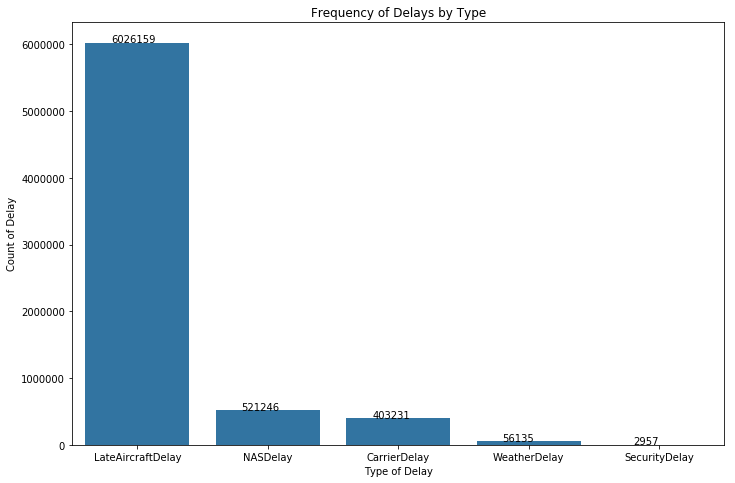

In [43]:
# labels = ['6,026,159','521,246','403,231','56,135','2,957']

gen_order = df_new.types.value_counts().index
plt.figure(figsize=[ 11.69, 7.77])

base_color = sb.color_palette()[0]
ax = sb.countplot(data=df_new,x='types', color=base_color, order= gen_order)
plt.xticks()
plt.xlabel('Type of Delay')
plt.ylabel('Count of Delay')
plt.title('Frequency of Delays by Type')
for p, label in zip(ax.patches, df_new["types"].value_counts()):
    ax.annotate(label, (p.get_x()+.2, p.get_height()+0.3));

An analysis of delays by type shows that the most frequent delays are late aircraft delays (more than 10x higher than other categories).

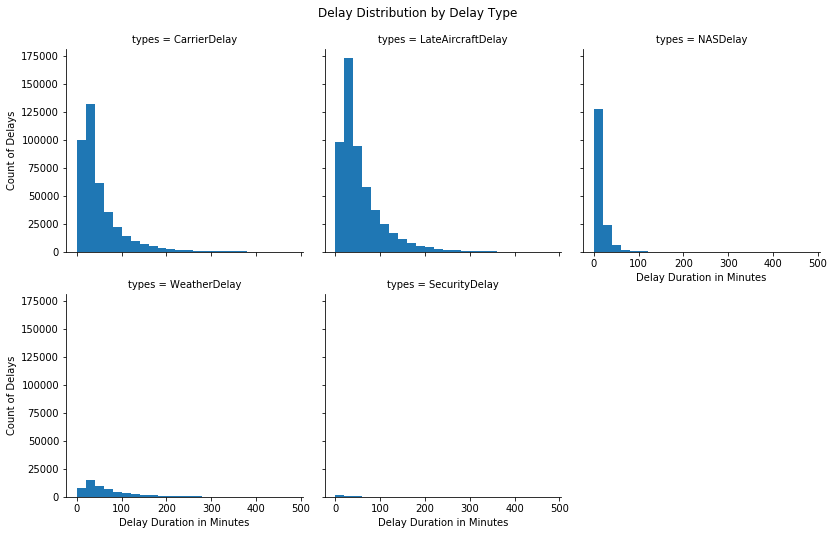

In [35]:
bins = np.arange(0.1,500,20)
g = sb.FacetGrid(data=df_new, col='types', col_wrap=3, height = 7.77/2,  aspect = (11.69/3)/(7.77/2))
g.map(plt.hist, 'total_delay', bins=bins)
g.set_xlabels('Delay Duration in Minutes')
g.set_ylabels('Count of Delays')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Delay Distribution by Delay Type')

plt.show();

We can see that the distributions for all delay types are right skewed which is not surprising. By looking at the scatterplots, we see that the longest delays are attributed to carrier delays, followed closely by late aircraft and weather delays.

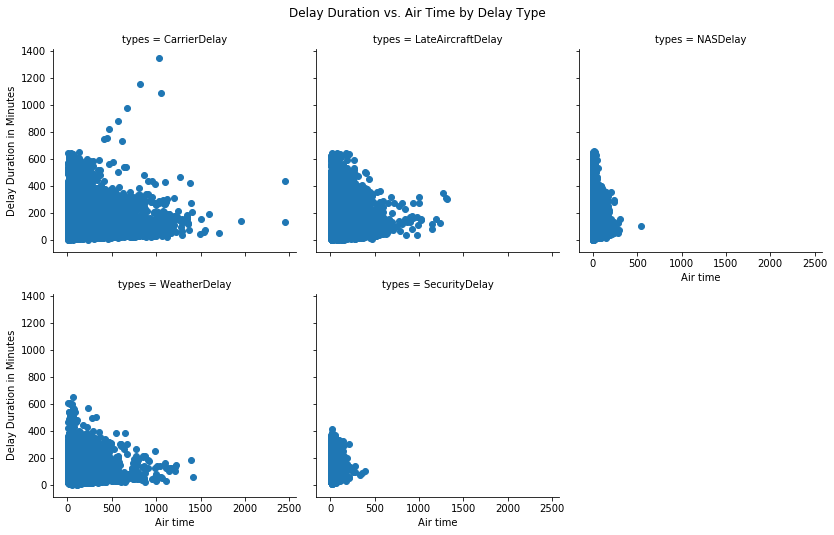

In [36]:
g = sb.FacetGrid(data=df_new, col='types',col_wrap=3, height = 7.77/2,  aspect = (11.69/3)/(7.77/2))
g.map(plt.scatter, 'total_delay','AirTime')
g.set_xlabels('Air time')
g.set_ylabels('Delay Duration in Minutes')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
g.fig.suptitle('Delay Duration vs. Air Time by Delay Type')
plt.show();

Overall, weather delays are far less frequent and shorter than I would have thought, especially as this data is for the USA which experiences harsh winters in many areas.

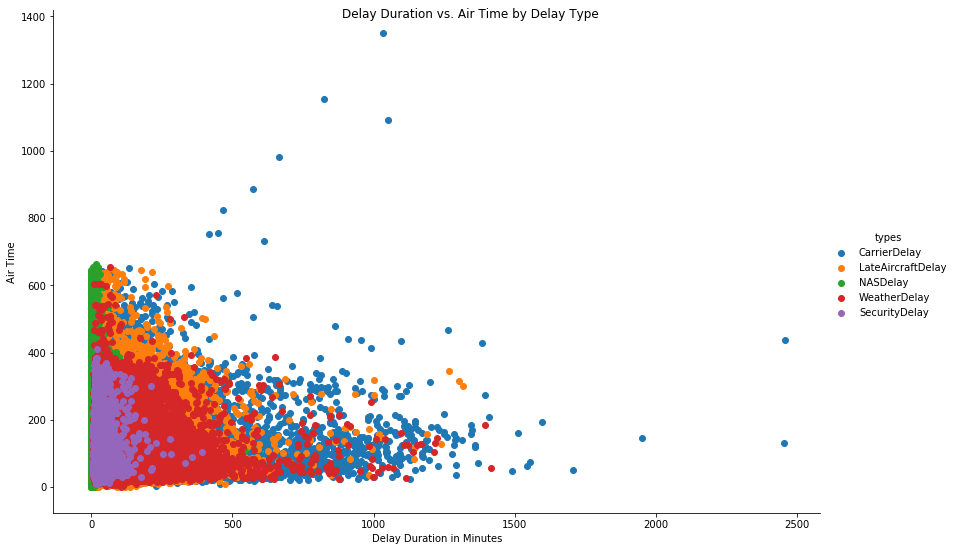

In [44]:
g = sb.FacetGrid(data = df_new, hue = 'types', height = 7.77,  aspect = (11.69)/(7.77))
g.map(plt.scatter, 'total_delay','AirTime' )
g.add_legend()
g.set_xlabels('Delay Duration in Minutes')
g.set_ylabels('Air Time')
g.fig.suptitle('Delay Duration vs. Air Time by Delay Type');

We can see that the longest flights and the longest delays are attributed to 'carrier delays', even though late aircraft delays are the most common as we saw in previous visualizations. 

### Analysis by Carrier

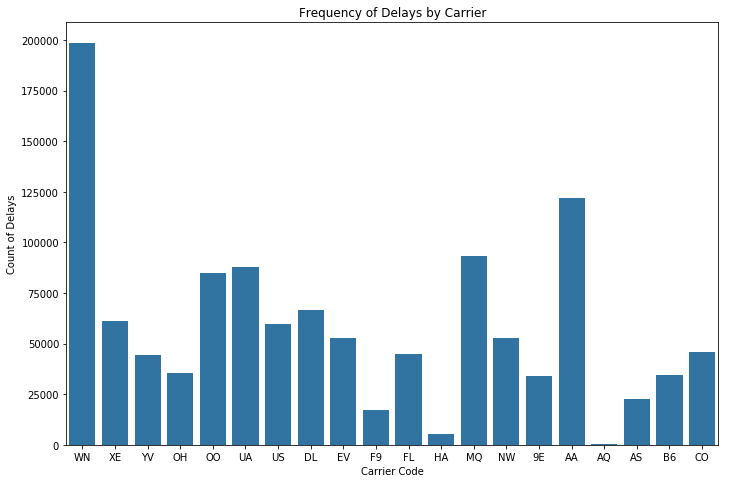

In [20]:
base_color = sb.color_palette()[0]
plt.figure(figsize=[ 11.69, 7.77])

sb.countplot(data=df_delays,x='UniqueCarrier', color=base_color)
plt.xticks()
plt.xlabel('Carrier Code')
plt.ylabel('Count of Delays')
plt.title('Frequency of Delays by Carrier');


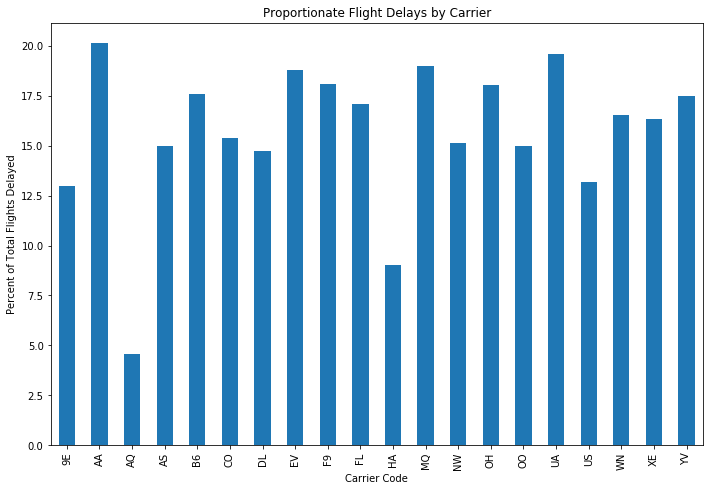

In [30]:
#number of delays as a % of total flights by carrier

total_flights = df.UniqueCarrier.value_counts()
delayed_flights = df_delays.UniqueCarrier.value_counts()
percent_delayed = (delayed_flights/total_flights)*100

base_color = sb.color_palette()[0]
plt.figure(figsize=[ 11.69, 7.77])

percent_delayed.plot(kind='bar',color=base_color);
plt.xlabel('Carrier Code')
plt.xticks()
plt.ylabel('Percent of Total Flights Delayed')
plt.title('Proportionate Flight Delays by Carrier');

Can see that carrier WN (Southwest) has most frequent delays, but not the highest proportionate delays. American Airlines (AA) ranks quite high proportionately, and from a frequency standpoint. United Airlines has the second highest proportion of flight delays at just under 20%. This is ironic as I am currently sitting in an airport completing this project, and have just discovered my UA flight has been delayed. 

In [ ]:
g.map(plt.scatter, 'total_delay','AirTime',alpha= .25)
g.set_xlabels('Air time')
g.set_ylabels('Delay Duration in minutes')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
g.fig.suptitle('Delay Duration vs. Air Time by Carrier')
plt.show();

The scatter plots highlight that carrier HA has the longest flight time, while carrier NW has the longest delays.

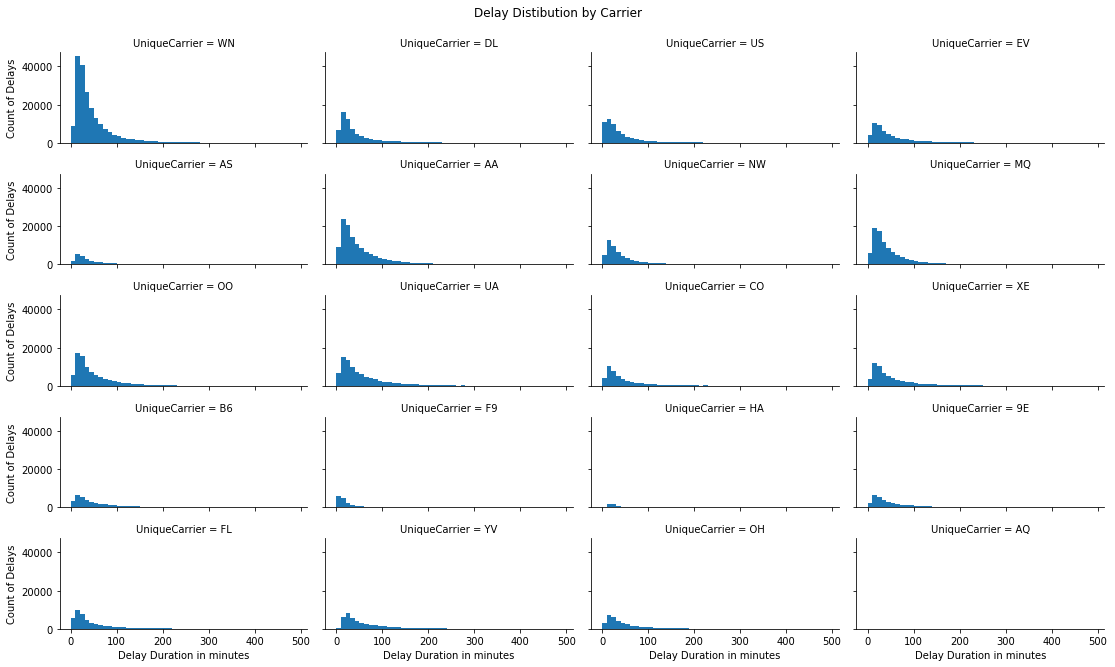

In [31]:
#distribution of delays by carrier

bins = np.arange(0.1,500,10)

g = sb.FacetGrid(data=df_new, col='UniqueCarrier', col_wrap=4, height = 7.77/4,  aspect = (11.69/3)/(7.77/4))
g.map(plt.hist, 'total_delay',bins=bins)
g.set_xlabels('Delay Duration in minutes')
g.set_ylabels('Count of Delays')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
g.fig.suptitle('Delay Distibution by Carrier')
plt.show();

Proportionately, AA has the most delays (overall this may be the worst airline in terms of delays judging by the frequency and length of the delays).

### Analysis by Origin & Destination

For this section I created a new dataframe of airports with delays with value counts of greater than 25,000 for both origin airports and departure airports. This was to focus my analysis on airports with the greatest number of delays. 



In [25]:
#create new df of origins with value counts > 25,0000 to analyze most frequent origin of delays

df_origin = df_delays.groupby("Origin").filter(lambda x: len(x) > 30000)

#do the same for destinations

df_dest = df_delays.groupby("Dest").filter(lambda x: len(x) > 25000)

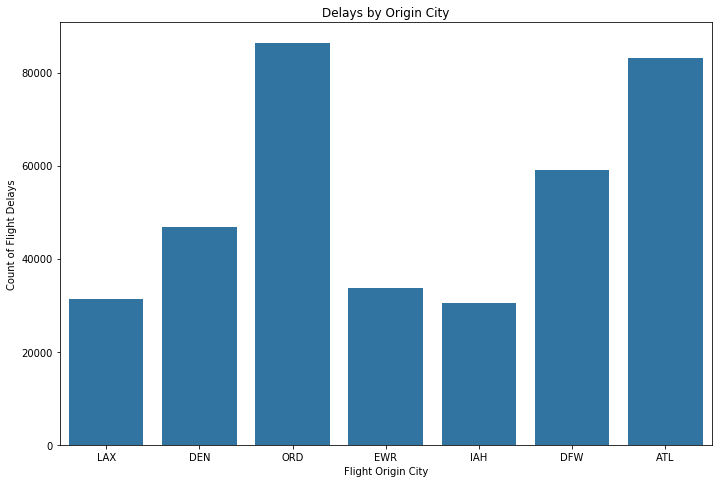

In [26]:
base_color = sb.color_palette()[0]
plt.figure(figsize=[ 11.69, 7.77])

sb.countplot(data = df_origin, x='Origin', color=base_color)
plt.xticks()
plt.xlabel('Flight Origin City')
plt.ylabel('Count of Flight Delays')
plt.title('Delays by Origin City');

We can see that the most frequent flight delays in terms of originating airports are for flights originating from Orlando (ORD) and Atlanta (ATL)

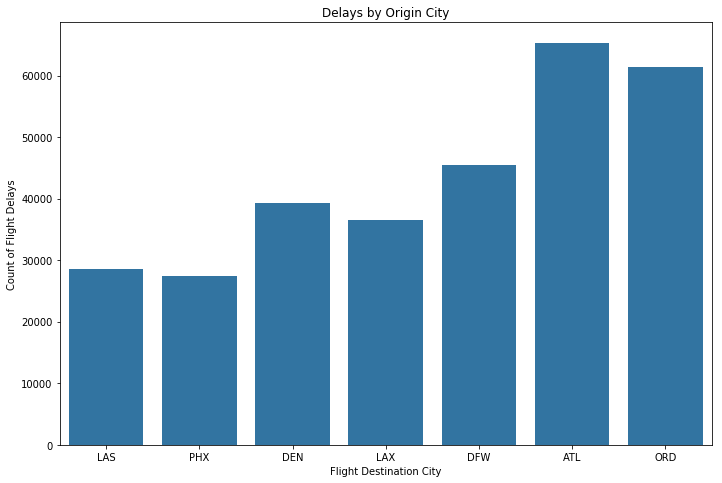

In [27]:
base_color = sb.color_palette()[0]
plt.figure(figsize=[ 11.69, 7.77])

sb.countplot(data = df_dest, x='Dest', color=base_color)
plt.xticks()
plt.xlabel('Flight Destination City')
plt.ylabel('Count of Flight Delays')
plt.title('Delays by Origin City');

We can see that again, the most frequent flight delays in terms of destination airport are for flights destined for Orlando (ORD) and Atlanta (ATL). 

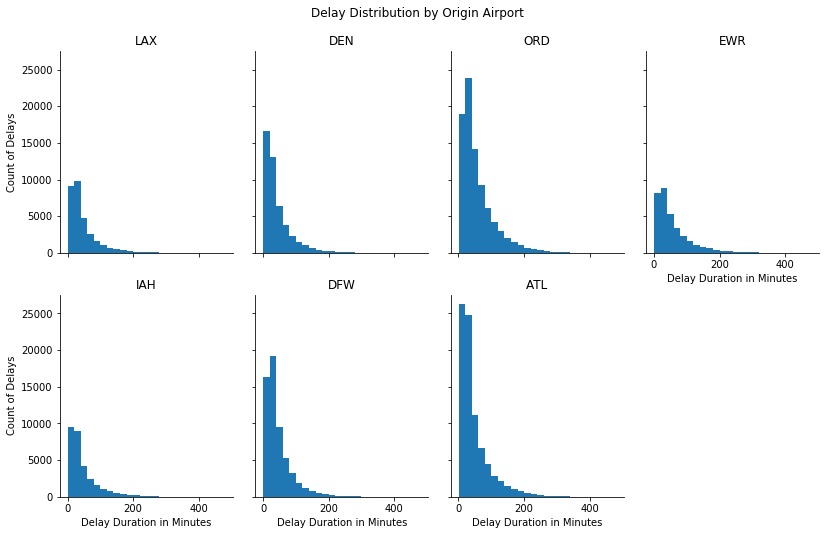

In [38]:
#distribution of delays by Origin

bins = np.arange(0.1,500,20)
g = sb.FacetGrid(data=df_origin, col='Origin', col_wrap=4, height = 7.77/2,  aspect = (11.69/4)/(7.77/2))
g.map(plt.hist, 'total_delay',bins=bins)



axes = g.axes.flatten()
axes[0].set_title("LAX")
axes[1].set_title("DEN")
axes[2].set_title("ORD")
axes[3].set_title("EWR")
axes[4].set_title("IAH")
axes[5].set_title("DFW")
axes[6].set_title("ATL")

g.set_xlabels('Delay Duration in Minutes')
g.set_ylabels('Count of Delays')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
g.fig.suptitle('Delay Distribution by Origin Airport')
plt.show();

Analyzing the distribution of delays by origin airport further shows that Orlando (ORD) and Atlanta (ATL) have the most frequent, and some of the longest duration delays. 

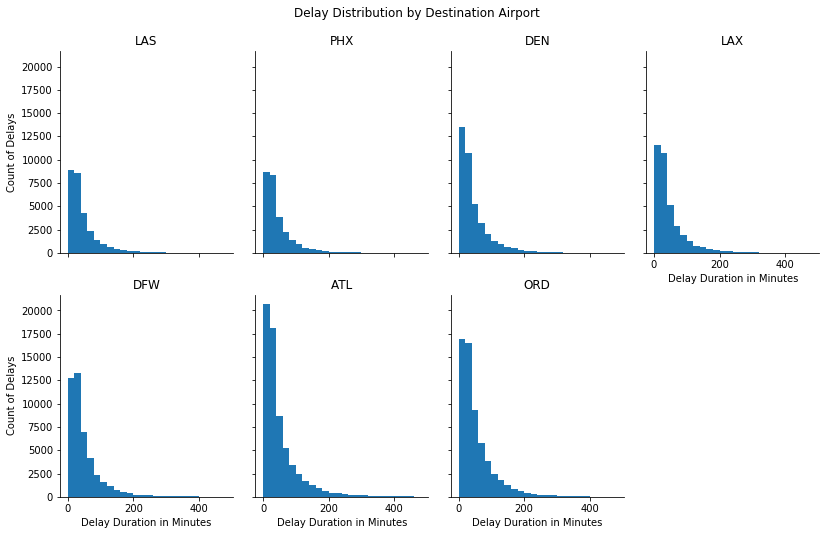

In [39]:
#distribution of delays by Destination

bins = np.arange(0.1,500,20)
g = sb.FacetGrid(data=df_dest, col='Dest', col_wrap=4, height = 7.77/2,  aspect = (11.69/4)/(7.77/2))
g.map(plt.hist, 'total_delay',bins=bins)


axes = g.axes.flatten()
axes[0].set_title("LAS")
axes[1].set_title("PHX")
axes[2].set_title("DEN")
axes[3].set_title("LAX")
axes[4].set_title("DFW")
axes[5].set_title("ATL")
axes[6].set_title("ORD")


g.set_xlabels('Delay Duration in Minutes')
g.set_ylabels('Count of Delays')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
g.fig.suptitle('Delay Distribution by Destination Airport')
plt.show();

I was not surprised to see that Atlanta and Chicago are the most frequent offenders as destination airports for delays in terms of frequency and duration.

### Analysis by Time of Year / Day of Week


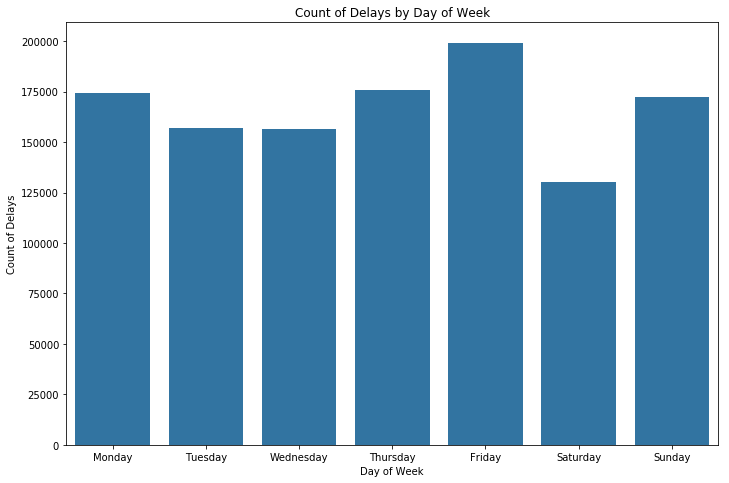

In [23]:
base_color = sb.color_palette()[0]
plt.figure(figsize=[ 11.69, 7.77])

sb.countplot(data = df_delays, x='DayOfWeek', color=base_color)
plt.xticks()
plt.xlabel('Day of Week')
plt.ylabel('Count of Delays')
plt.title('Count of Delays by Day of Week');

It was interessting to look at the distrubution of delays by Day of the Week. It is not surprising to see that the most delays occured on a Friday, as this is likely business travellers returning home, and vacationers leaving for weekend trips. 

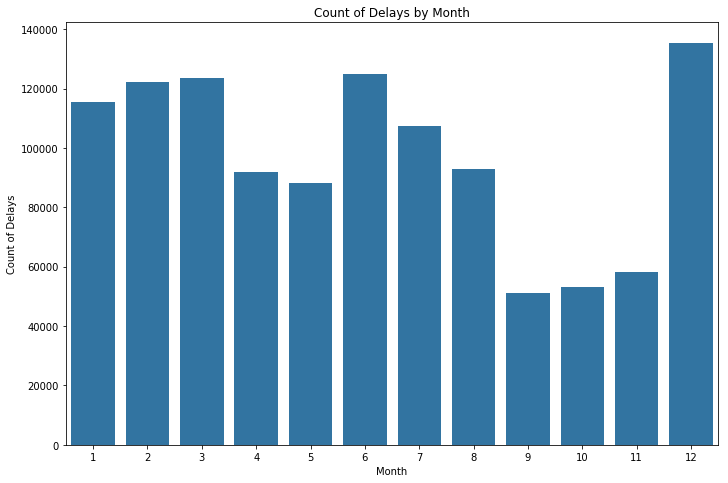

In [22]:
base_color = sb.color_palette()[0]
plt.figure(figsize=[ 11.69, 7.77])

sb.countplot(data = df_delays, x='Month', color=base_color)
plt.xticks()
plt.xlabel('Month')
plt.ylabel('Count of Delays')
plt.title('Count of Delays by Month');

I also was not surprised to see that the majority of delays occured in December and the winter months, likely to weather related issues causing carrier, weather and late aircraft delays.